# XRF tomography data from beamline 2-ID-E

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyxalign
results_folder = "/local/hruth/2ide_xrf_tomo_example_results/"

## Load the XRF data

In [3]:
xrf_load = pyxalign.io.loaders.xrf # create an alias
# setup loading options
base = pyxalign.io.loaders.xrf.XRFBaseLoadOptions(
    folder="/net/micdata/data1/2ide/2025-1/Isik-2-large/img.dat/",
    scan_start=27,
    scan_end=176,
)
xrf_loading_options = xrf_load.XRF2IDELoadOptions(base=base)
# load xrf data
xrf_standard_data_dict = xrf_load.load_data_from_xrf_format(xrf_loading_options)

In [9]:
# use the interactive viewer to look at the zinc data
gui = pyxalign.gui.launch_standard_data_viewer(xrf_standard_data_dict["Zn"])

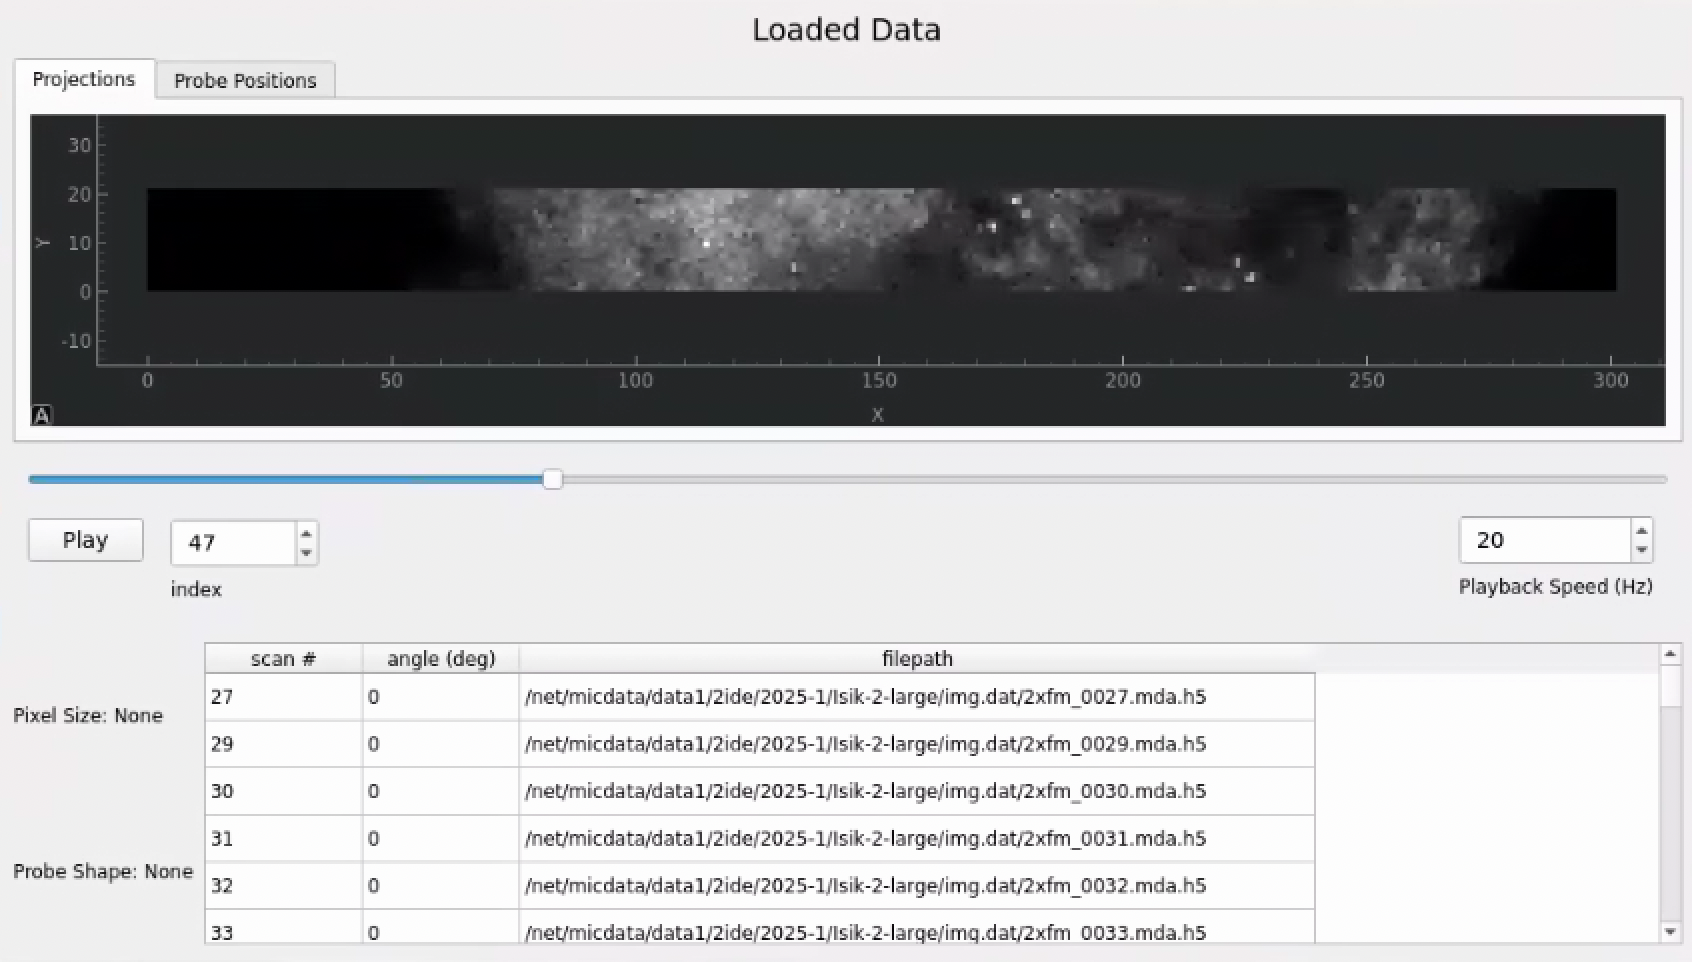

## The `XRFTask` object

### Convert dictionary of 2D arrays to 3D arrays for each element

In [ ]:
xrf_array_dict = xrf_load.convert_xrf_projection_dicts_to_arrays(
    xrf_standard_data_dict,
    pad_with_mode=True,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.13it/s]

Projection array shape: (149, 64, 320)


In [31]:
# specify projection options
projection_options = pyxalign.options.ProjectionOptions()
projection_options.experiment.laminography_angle = 90 # tomography

# Pick the channel that will be used for alignment.
# The channel with the strongest and clearest features
# is typicall a good choice.
primary_channel = "Zn"

xrf_task = pyxalign.data_structures.XRFTask(
    xrf_array_dict=xrf_array_dict,
    angles=xrf_standard_data_dict[primary_channel].angles,
    scan_numbers=xrf_standard_data_dict[primary_channel].scan_numbers,
    projection_options=projection_options,
    primary_channel=primary_channel,
    file_paths=list(xrf_standard_data_dict[primary_channel].file_paths.values()),
)

### Specify angles manually

The rotation angles were not saved in the files that pyxalign uses to load the data, so we have to specify the angles manually for this dataset.

XRFTask.angles cannot be updated in-place


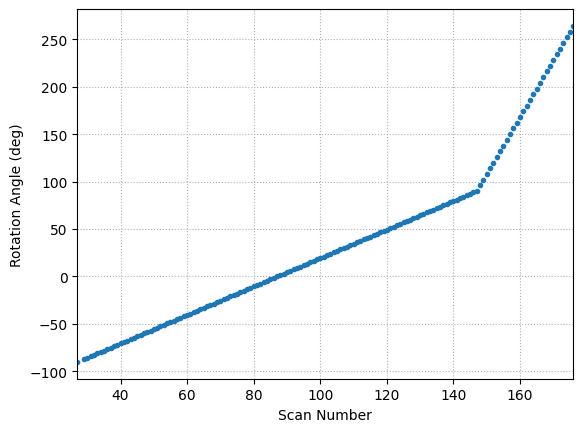

In [32]:
%matplotlib inline

# Manually assign angles from -90 to 90 to scan numbers 27 to 147 (inclusive)
scan_start = 27
scan_end = 147
scan_list = list(range(scan_start, scan_end + 1))
assigned_angles = np.linspace(-90, 90, len(scan_list))
new_angles = np.zeros_like(xrf_task.angles)

for i, ang in enumerate(assigned_angles):
    new_angles[xrf_task.scan_numbers == scan_list[i]] = ang

# Manually assign angles from 96 to 264 to scan numbers 148 to 176 (inclusive)
scan_start = 148
scan_end = 176
scan_list = list(range(scan_start, scan_end + 1))
assigned_angles = np.linspace(96, 264, len(scan_list))

for i, ang in enumerate(assigned_angles):
    new_angles[xrf_task.scan_numbers == scan_list[i]] = ang

# Assigning angles in-place (like below) will not work
try:
    xrf_task.angles[:] = new_angles
except Exception as ex:
    print("XRFTask.angles cannot be updated in-place")
# For XRFTask, assign angles this way
xrf_task.angles = new_angles

plt.figure()
plt.plot(xrf_task.scan_numbers, xrf_task.angles, '.')
plt.grid(ls=":")
plt.autoscale(True, "x", True)
plt.xlabel("Scan Number")
plt.ylabel("Rotation Angle (deg)")
plt.show()


### Open the XRF projections viewer and remove bad projections

In [47]:
gui = pyxalign.gui.launch_xrf_projections_viewer(xrf_task)

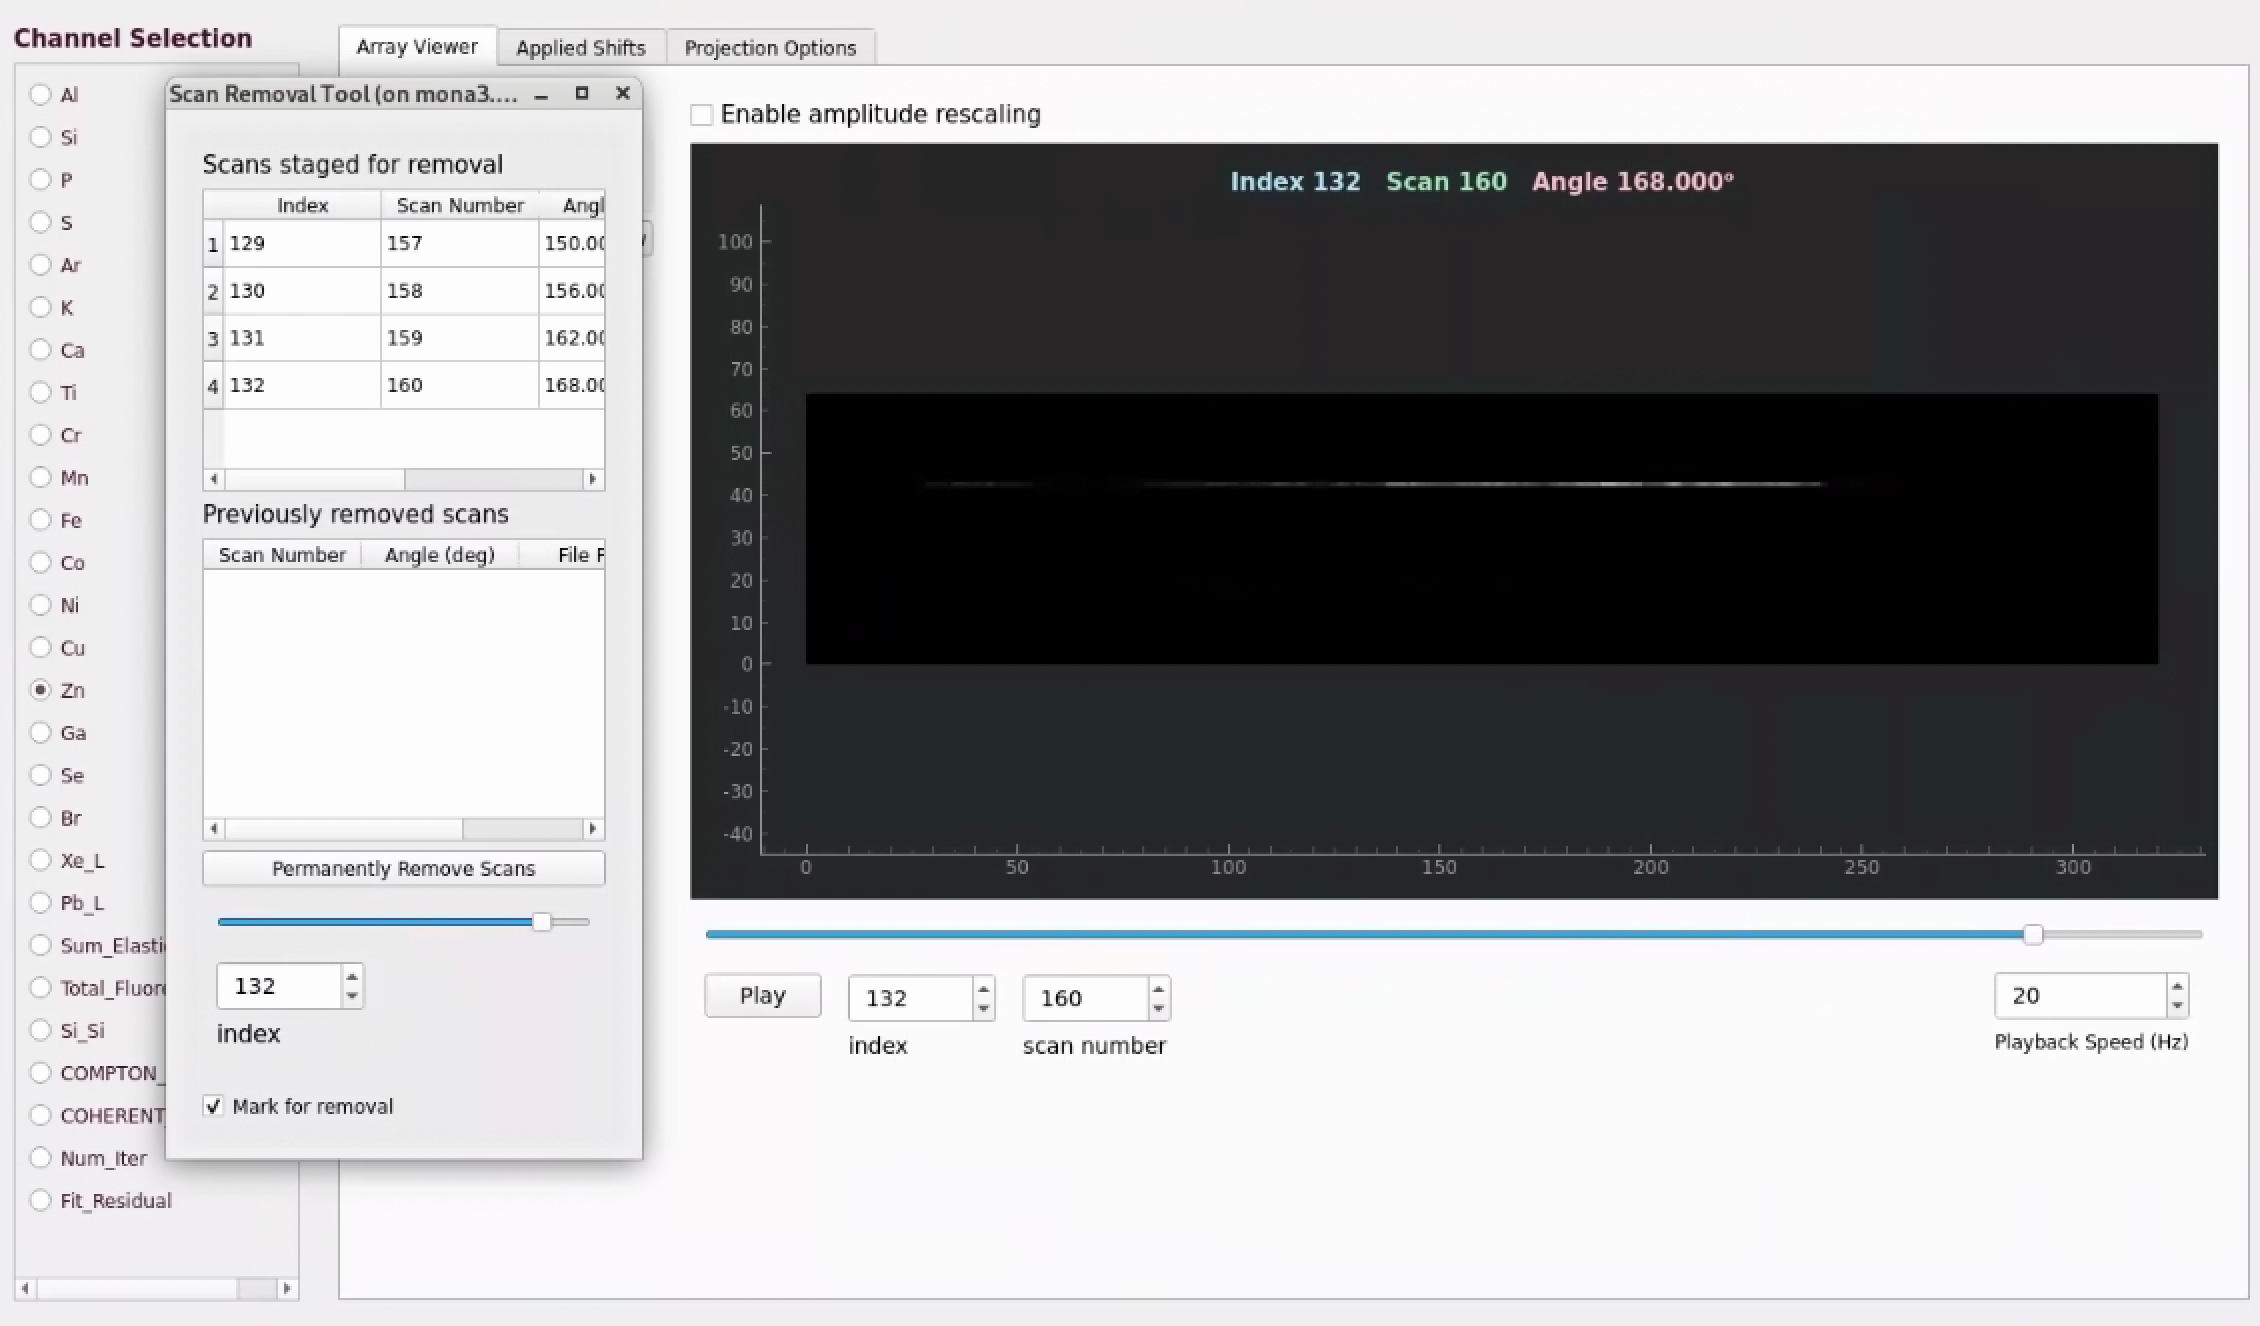

### Estimate center of rotation

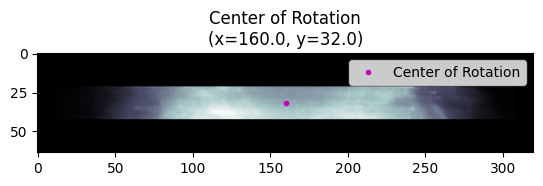

In [35]:
%matplotlib inline
xrf_task.projections_dict["Zn"].show_center_of_rotation()

Its hard to estimate exactly where the center of rotation is here, but the default guess looks good enough.

### Estimate sample thickness

Increase `sample_thickness` and get 3D reconstructions before doing projection matching alignment

In [42]:
xrf_task.projection_options.experiment.pixel_size = 1 # we don't know the pixel size
xrf_task.projection_options.experiment.sample_thickness = 100
xrf_task.get_3D_reconstructions_for_all_channels()

Open XRF volume viewer

In [44]:
gui = pyxalign.gui.launch_xrf_volume_viewer(xrf_task)

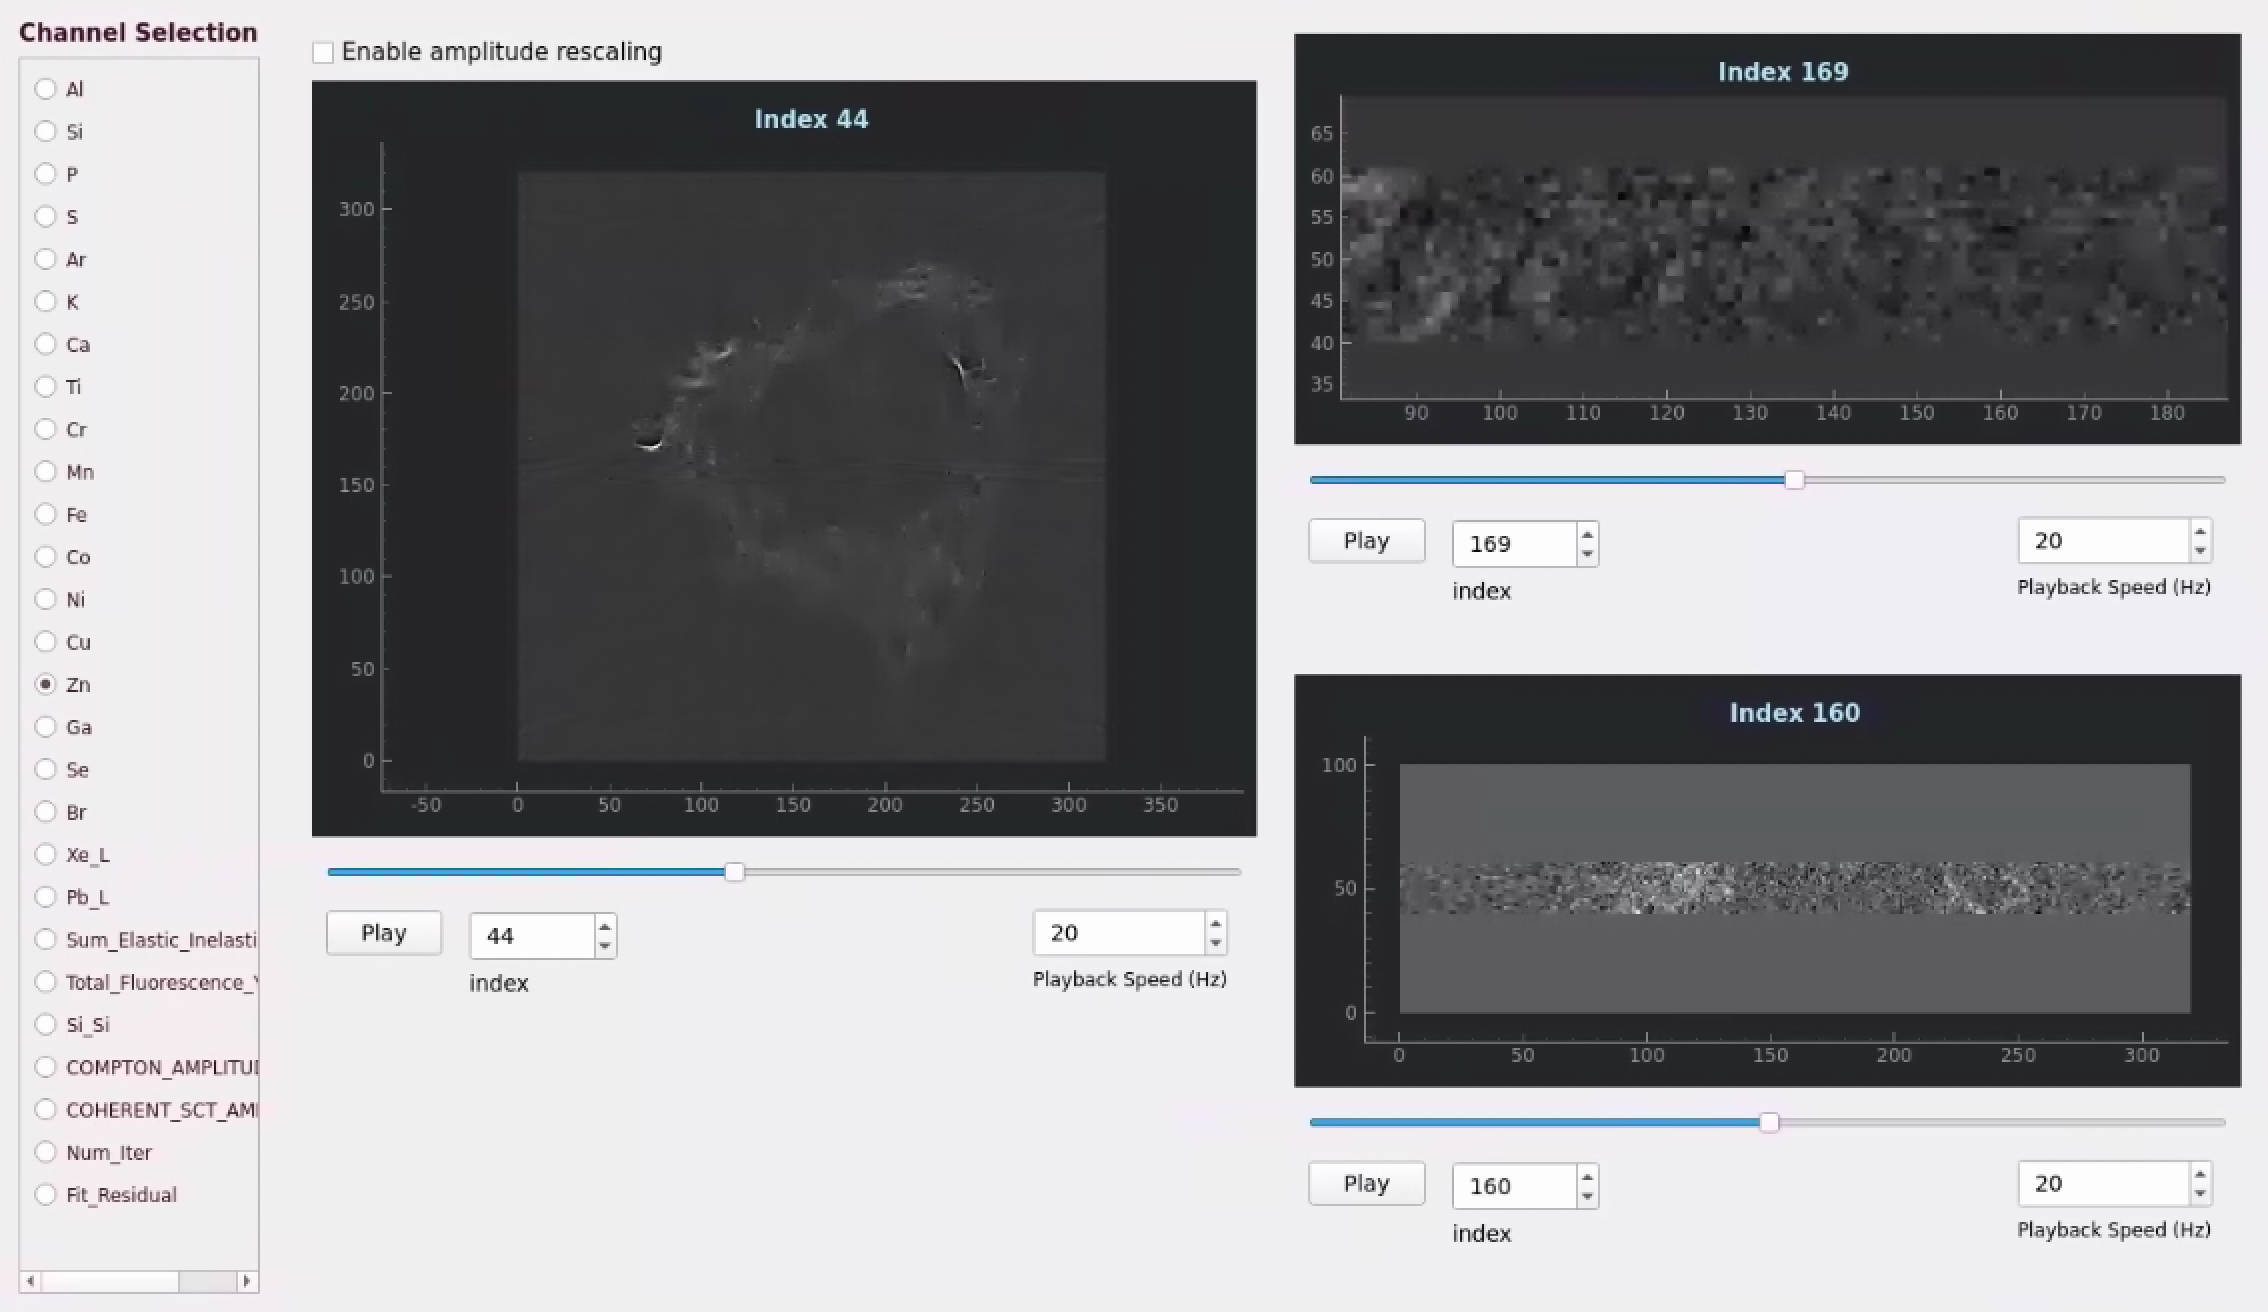

This thickness is too big; I typically choose a thickness that is slightly larger than the actual volume width.

In [49]:
xrf_task.projection_options.experiment.sample_thickness = 40
xrf_task.get_3D_reconstructions_for_all_channels()
gui = pyxalign.gui.launch_xrf_volume_viewer(xrf_task)

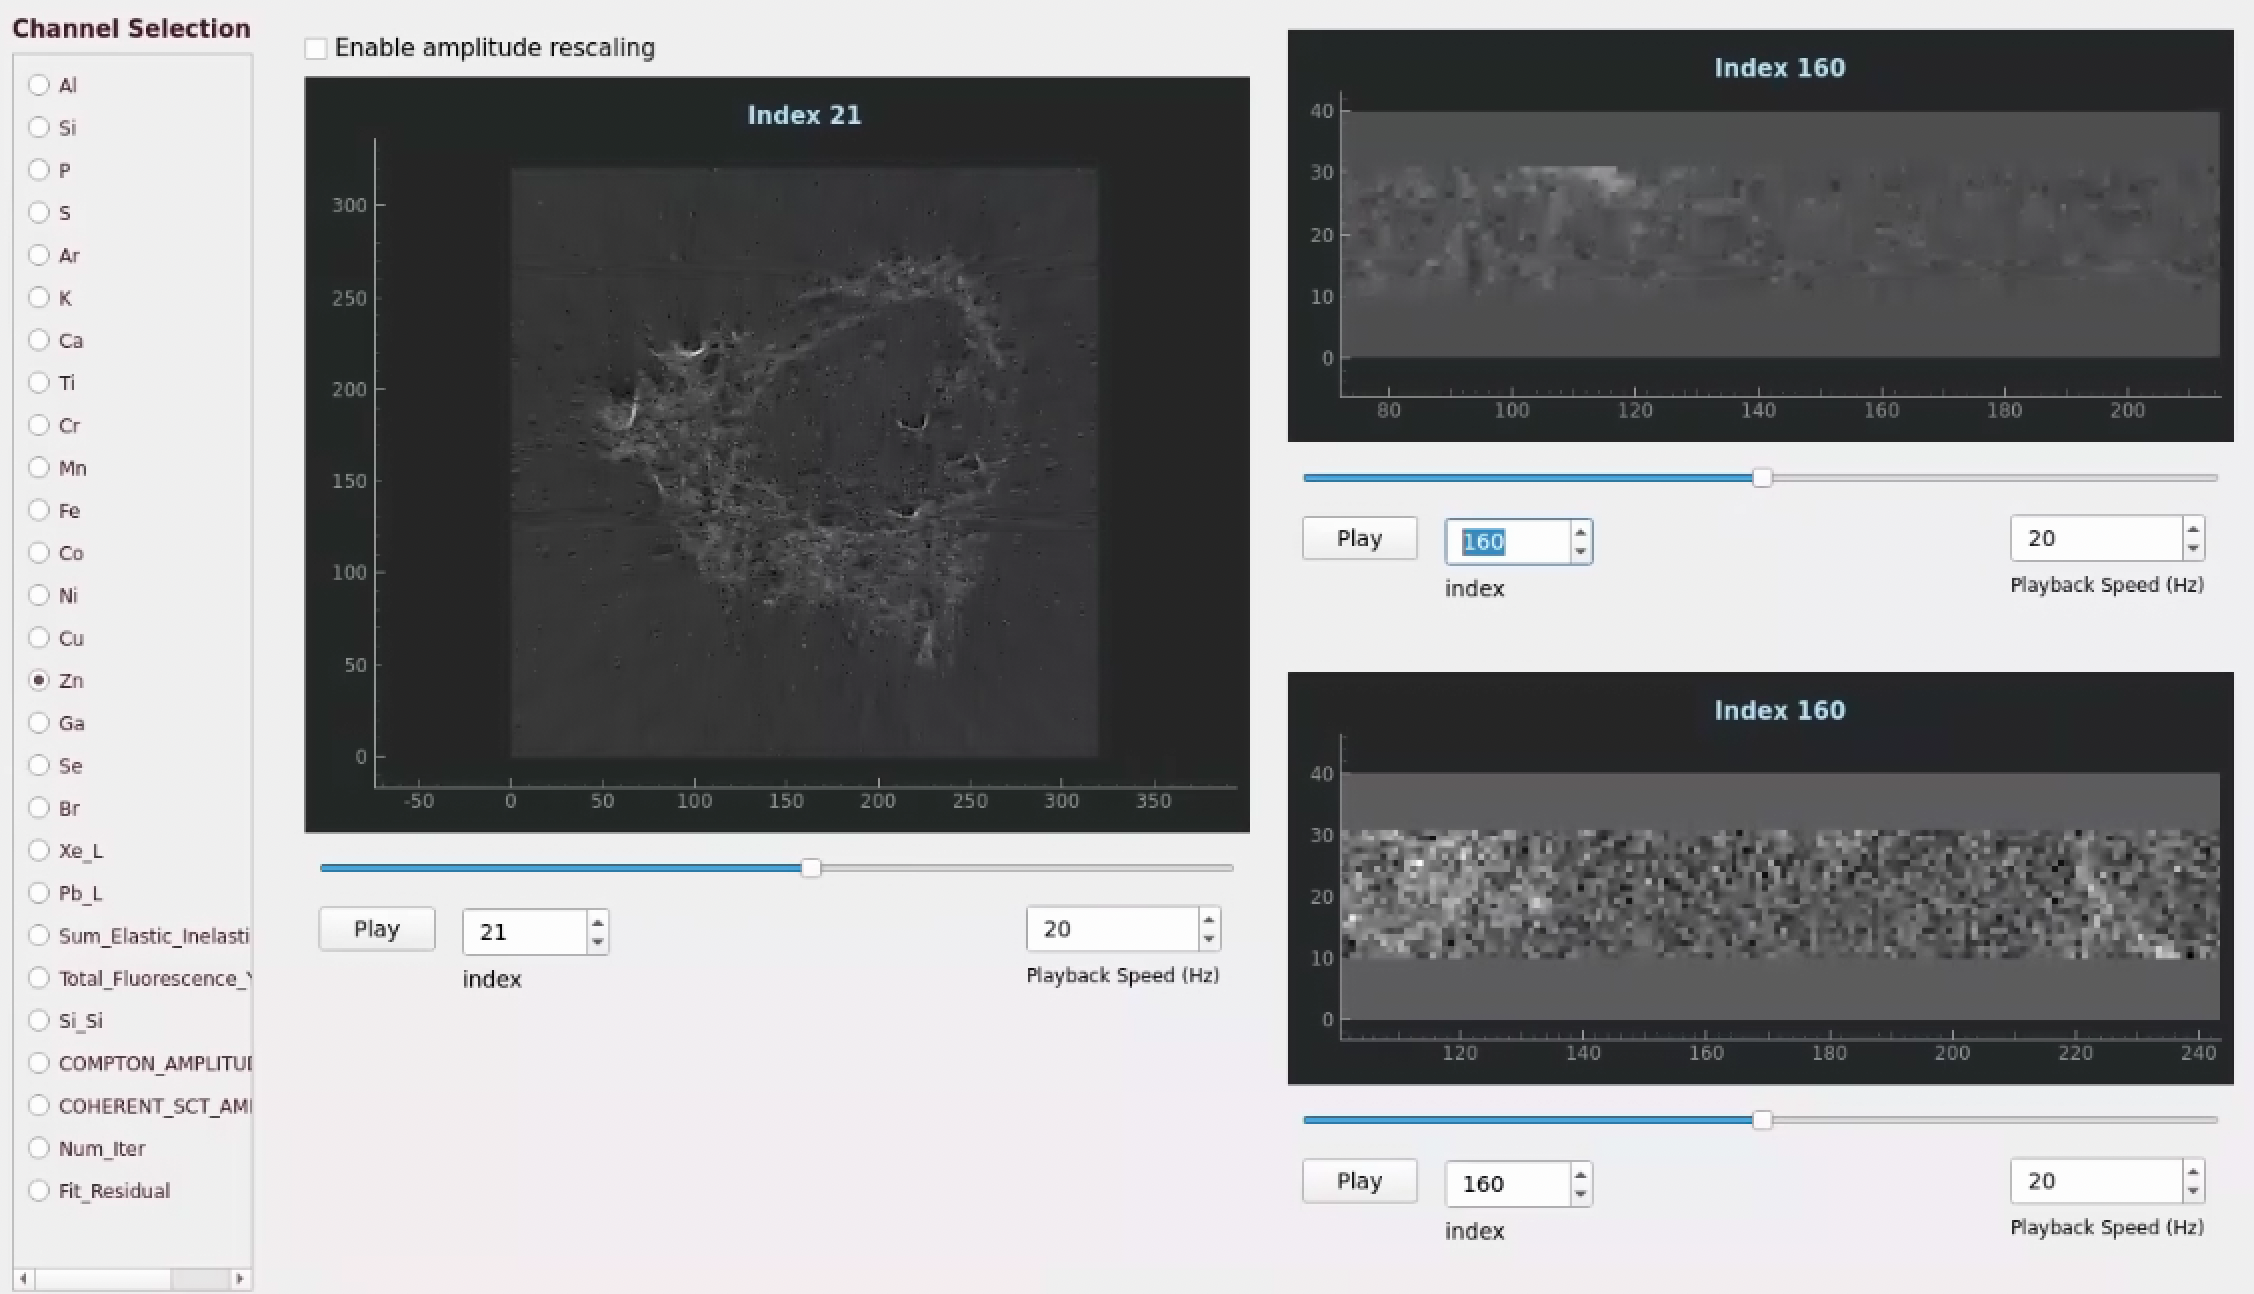

this is a better thickness

## Projection matching alignment

### Select appropriate settings

In [ ]:
pma_options = xrf_task.alignment_options.projection_matching
pma_options.keep_on_gpu = True
pma_options.high_pass_filter = 0.01
pma_options.min_step_size = 0.001
pma_options.iterations = 1000
pma_options.downsample.enabled = True
pma_options.mask_shift_type = pyxalign.enums.ShiftType.FFT
pma_options.projection_shift_type = pyxalign.enums.ShiftType.FFT
pma_options.momentum.enabled = True
pma_options.prevent_wrapping_from_shift = True
# 3D volume processing
pma_options.regularization.enabled = True  
pma_options.regularization.local_TV_lambda = 1e-1
pma_options.positivity_constraint.enabled = True

pma_options.interactive_viewer.update.enabled = True
pma_options.interactive_viewer.update.stride = 50

In [51]:
# create a masked region for projection matching alignment; this will be done
# automatically or with a GUI in the future
xrf_task.projections_dict[xrf_task._primary_channel].masks = np.ones_like(
    xrf_task.projections_dict[xrf_task._primary_channel].data
)

### Start the multi-resolution alignment sequence

In [52]:
pma_options.downsample.scale = 4
shift = xrf_task.get_projection_matching_shift()

image_downsample_linear: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 70.95it/s]


Starting projection-matching alignment downsampling = 4...


Max step size update: 0.0010 px Momentum acceleration: [61.17 20.35] Friction: 0.04:  19%|█████████████████████▏                                                                                           | 187/1000 [00:44<03:13,  4.20it/s]


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shifts stored in shift_manager


In [55]:
pma_options.downsample.scale = 2
shift = xrf_task.get_projection_matching_shift(shift)

image_downsample_linear: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 67.13it/s]


Starting projection-matching alignment downsampling = 2...


Max step size update: 0.0010 px Momentum acceleration: [45.02 22.04] Friction: 0.02:  25%|███████████████████████████▊                                                                                     | 246/1000 [01:56<05:57,  2.11it/s]


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shifts stored in shift_manager


In [57]:
pma_options.downsample.scale = 1
pma_options.regularization.enabled = False
pma_options.momentum.enabled = False
shift = xrf_task.get_projection_matching_shift(shift)

Projection-matching shifts stored in shift_manager


In [ ]:
# increase high pass filter
pma_options.high_pass_filter = 0.05
# increase step relaxation multiplier
pma_options.step_relax = 0.5
shift = xrf_task.get_projection_matching_shift(shift)

Projection-matching shifts stored in shift_manager


### Apply alignment shift

In [61]:
xrf_task.apply_staged_shift_to_all_channels()

### Save aligned `XRFTask`

In [63]:
xrf_task.save_task(os.path.join(results_folder, "aligned_xrf_task.h5"))

projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Al
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Si
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/P
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/S
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Ar
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/K


projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Ca
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Ti
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Cr
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Mn
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Fe
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Co
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Ni
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Cu
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Zn
projections saved to /local/hruth/2ide_xrf_tomo_example_results/aligned_xrf_task.h5/projections/Ga
projection

## Final 3D reconstructions

### Get 3D reconstructions

In [64]:
xrf_task.get_3D_reconstructions_for_all_channels()

### Use XRF volume viewer

In [65]:
gui = pyxalign.gui.launch_xrf_volume_viewer(xrf_task)

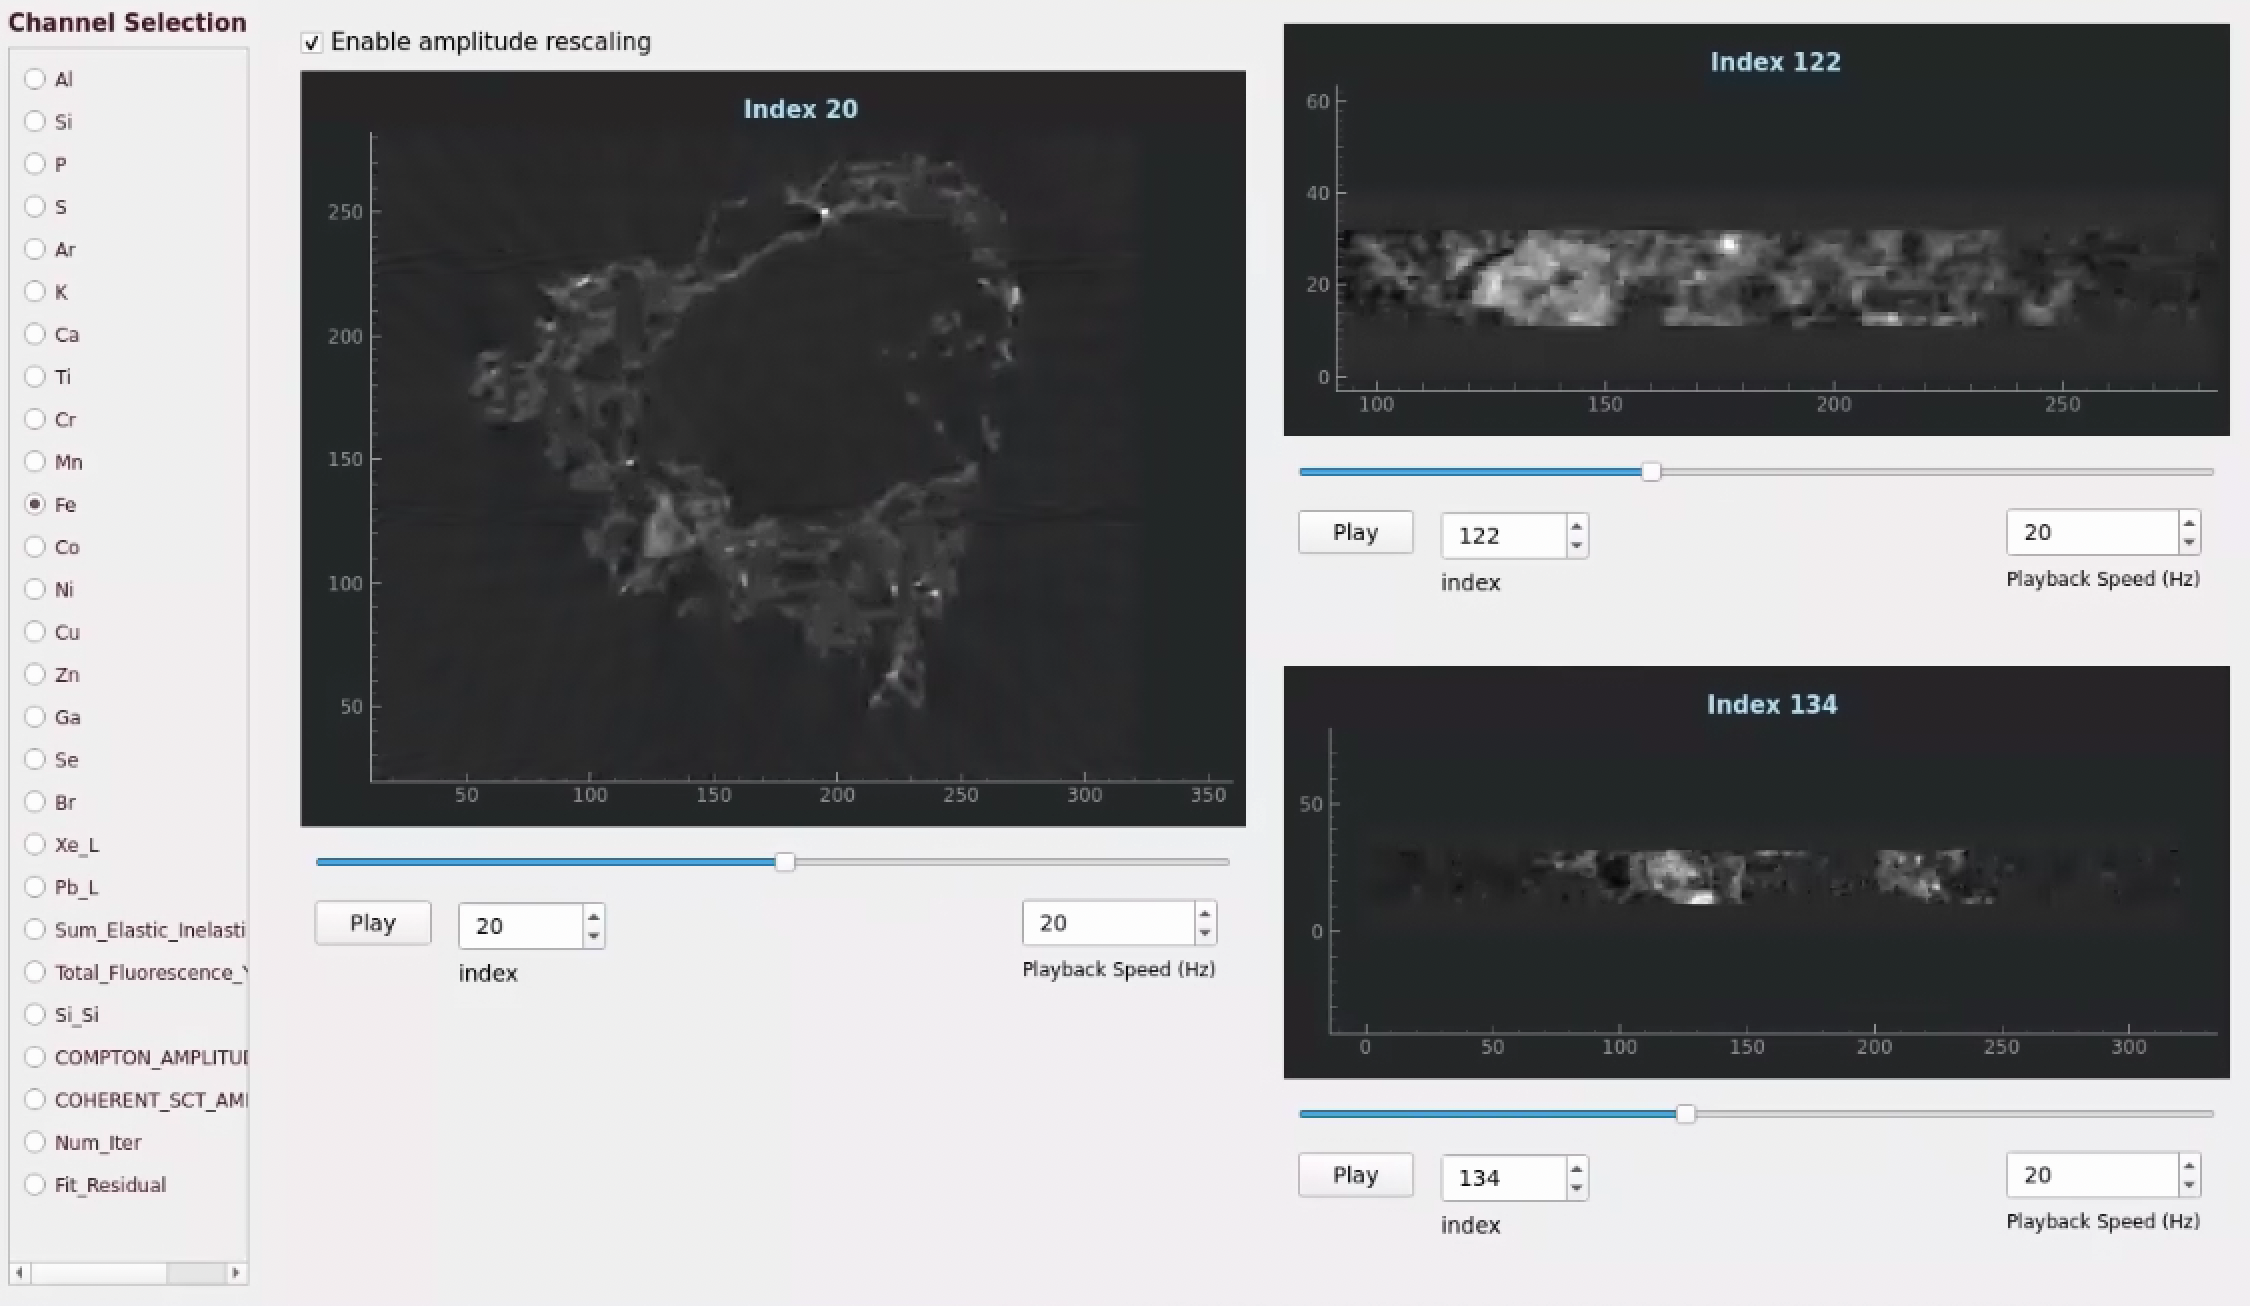

### Save a 3D TIFF file for each channel

In [67]:
xrf_task.save_volumes_as_tiffs(results_folder=results_folder, file_prefix="aligned_volume_")

File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Al.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Si.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_P.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_S.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Ar.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_K.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Ca.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Ti.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Cr.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Mn.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Fe.tiff
File saved to: /local/hruth/2ide_xrf_tomo_example_results/aligned_volume_Co.tiff
File saved to: /local/hruth/2id